In [1]:
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
base_dir = "dataset/rgb/224/"
folders = glob(base_dir + "/*")

print("Total class:", len(folders))
os.listdir(base_dir)

Total class: 3


['224_rgb_bopeng', '224_rgb_jerawat', '224_rgb_komedo']

In [3]:
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split("\\")[-1])
        file_name.append(name)

In [4]:
df = pd.DataFrame({"path": full_path, "file_name": file_name, "tag": tag})
df.groupby(["tag"]).size()

tag
dataset/rgb/224/224_rgb_bopeng     750
dataset/rgb/224/224_rgb_jerawat    750
dataset/rgb/224/224_rgb_komedo     750
dtype: int64

In [5]:
df

,path,file_name,tag
0,dataset/rgb/224/224_rgb_bopeng\b_0_1280.jpg,b_0_1280.jpg,dataset/rgb/224/224_rgb_bopeng
1,dataset/rgb/224/224_rgb_bopeng\b_0_211.jpg,b_0_211.jpg,dataset/rgb/224/224_rgb_bopeng
2,dataset/rgb/224/224_rgb_bopeng\b_0_2161.jpg,b_0_2161.jpg,dataset/rgb/224/224_rgb_bopeng
3,dataset/rgb/224/224_rgb_bopeng\b_0_2247.jpg,b_0_2247.jpg,dataset/rgb/224/224_rgb_bopeng
4,dataset/rgb/224/224_rgb_bopeng\b_0_2772.jpg,b_0_2772.jpg,dataset/rgb/224/224_rgb_bopeng
...,...,...,...
2245,dataset/rgb/224/224_rgb_komedo\k_9_7992.jpg,k_9_7992.jpg,dataset/rgb/224/224_rgb_komedo
2246,dataset/rgb/224/224_rgb_komedo\k_9_8124.jpg,k_9_8124.jpg,dataset/rgb/224/224_rgb_komedo
2247,dataset/rgb/224/224_rgb_komedo\k_9_8639.jpg,k_9_8639.jpg,dataset/rgb/224/224_rgb_komedo
2248,dataset/rgb/224/224_rgb_komedo\k_9_9360.jpg,k_9_9360.jpg,dataset/rgb/224/224_rgb_komedo


In [6]:
X = df["path"]
y = df["tag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [7]:
data_train = pd.DataFrame({"path": X_train, "tag": y_train, "set": "train"})
data_val = pd.DataFrame({"path": X_val, "tag": y_val, "set": "valid"} )

In [8]:
print("train_size", len(data_train))
print("valid_size", len(data_val))

train_size 1800
valid_size 450


In [9]:
df_all = data_train.append([data_val]).reset_index(drop=1)
print(df_all.groupby(["set", "tag"]).size(), "\n")

# Cek sample data
df_all

set    tag                            
train  dataset/rgb/224/224_rgb_bopeng     600
       dataset/rgb/224/224_rgb_jerawat    600
       dataset/rgb/224/224_rgb_komedo     600
valid  dataset/rgb/224/224_rgb_bopeng     150
       dataset/rgb/224/224_rgb_jerawat    150
       dataset/rgb/224/224_rgb_komedo     150
dtype: int64 



,path,tag,set
0,dataset/rgb/224/224_rgb_jerawat\j_43_3131.jpg,dataset/rgb/224/224_rgb_jerawat,train
1,dataset/rgb/224/224_rgb_komedo\k_39_4577.jpg,dataset/rgb/224/224_rgb_komedo,train
2,dataset/rgb/224/224_rgb_komedo\k_26_5144.jpg,dataset/rgb/224/224_rgb_komedo,train
3,dataset/rgb/224/224_rgb_jerawat\j_6_2837.jpg,dataset/rgb/224/224_rgb_jerawat,train
4,dataset/rgb/224/224_rgb_bopeng\b_8_2902.jpg,dataset/rgb/224/224_rgb_bopeng,train
...,...,...,...
2245,dataset/rgb/224/224_rgb_komedo\k_26_6008.jpg,dataset/rgb/224/224_rgb_komedo,valid
2246,dataset/rgb/224/224_rgb_jerawat\j_32_6161.jpg,dataset/rgb/224/224_rgb_jerawat,valid
2247,dataset/rgb/224/224_rgb_komedo\k_3_2675.jpg,dataset/rgb/224/224_rgb_komedo,valid
2248,dataset/rgb/224/224_rgb_bopeng\b_31_9151.jpg,dataset/rgb/224/224_rgb_bopeng,valid


In [10]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
        data_train,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_dataframe(
        data_val,
        x_col="path",
        y_col="tag",
        target_size=(224, 224),
        class_mode="categorical"
)

Found 1800 validated image filenames belonging to 3 classes.
Found 450 validated image filenames belonging to 3 classes.


## Build Model

In [12]:
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)

In [13]:
for layers in vgg.layers:
    layers.trainable = False

In [14]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation="softmax")(x)

In [15]:
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
my_callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy", 
    min_delta=0.001, 
    patience=5,
    verbose=0,
    mode="max",
    restore_best_weights=True
)

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=my_callbacks
)

Epoch 1/50
57/57 [==============================] - 512s 9s/step - loss: 0.4952 - accuracy: 0.8067 - val_loss: 0.2418 - val_accuracy: 0.9044
Epoch 2/50
57/57 [==============================] - 670s 12s/step - loss: 0.1528 - accuracy: 0.9578 - val_loss: 0.1500 - val_accuracy: 0.9622
Epoch 3/50
57/57 [==============================] - 679s 12s/step - loss: 0.1080 - accuracy: 0.9728 - val_loss: 0.1025 - val_accuracy: 0.9822
Epoch 4/50
57/57 [==============================] - 656s 12s/step - loss: 0.0780 - accuracy: 0.9833 - val_loss: 0.1072 - val_accuracy: 0.9711
Epoch 5/50
57/57 [==============================] - 655s 12s/step - loss: 0.0621 - accuracy: 0.9861 - val_loss: 0.0841 - val_accuracy: 0.9844
Epoch 6/50
57/57 [==============================] - 655s 12s/step - loss: 0.0456 - accuracy: 0.9956 - val_loss: 0.0645 - val_accuracy: 0.9933
Epoch 7/50
57/57 [==============================] - 652s 11s/step - loss: 0.0391 - accuracy: 0.9961 - val_loss: 0.0563 - val_accuracy: 0.9911
Epoch 8

## Model Accuracy

In [20]:
test_loss, test_acc = model.evaluate(valid_generator)
print("\naccuracy:", test_acc, "  loss: ", test_loss)


15/15 [==============================] - 127s 8s/step - loss: 0.0439 - accuracy: 0.9889

accuracy: 0.9888888597488403   loss:  0.043903689831495285


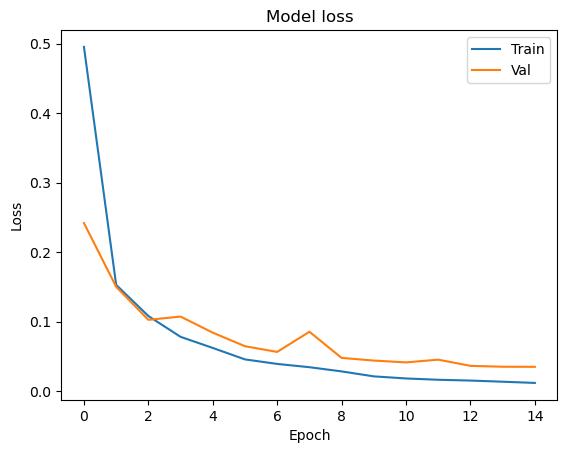

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

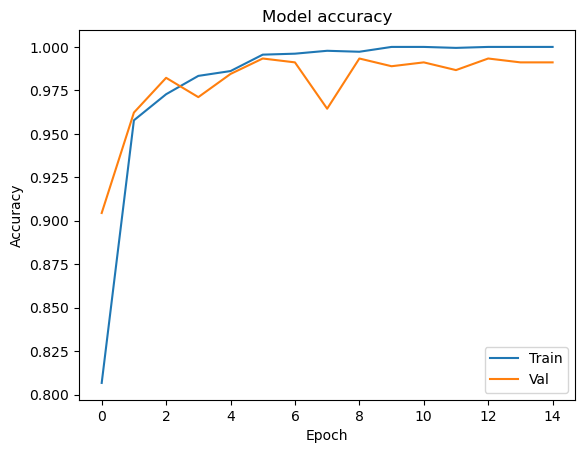

In [22]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="lower right")
plt.show()

## Save Model

In [23]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "model_224"
SAVE_MODEL_NAME = "vgg16-244-rgb.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print("Saving Model At {}...".format(save_model_path))
model.save(save_model_path)

Saving Model At model\model_224\vgg16-244-rgb.h5...


## Model Evaluate

In [18]:
model_load = load_model('model/model_224/vgg16-244-rgb.h5')

In [19]:
image_generator = ImageDataGenerator(rescale=1/255)
test_data = 'testing'
test_image_data = image_generator.flow_from_directory(test_data, target_size=(224, 224), batch_size=60)

Found 60 images belonging to 3 classes.


In [20]:
for image_batch, label_batch in test_image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break


Image batch shape:  (60, 224, 224, 3)
Label batch shape:  (60, 3)


In [21]:
predicted_batch = model_load.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

2/2 [==============================] - 9s 4s/step


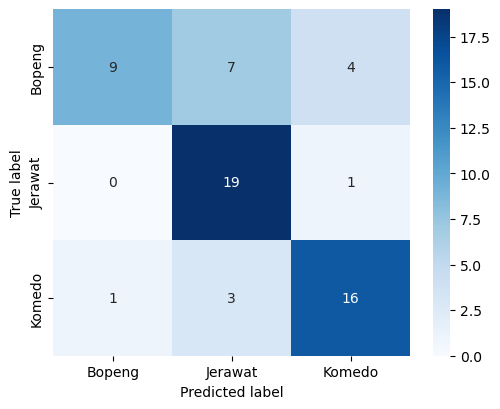

In [22]:
cf_matrix = confusion_matrix(label_id, predicted_id)
cm_df = pd.DataFrame(
    cf_matrix,
    index=["Bopeng", "Jerawat", "Komedo"],
    columns=["Bopeng", "Jerawat", "Komedo"]
)
figure = plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [23]:
faces = ['bopeng', 'jerawat', 'komedo']
classification_metrics = classification_report(label_id, predicted_id, target_names=faces, zero_division=0)
print(classification_metrics)

              precision    recall  f1-score   support

      bopeng       0.90      0.45      0.60        20
     jerawat       0.66      0.95      0.78        20
      komedo       0.76      0.80      0.78        20

    accuracy                           0.73        60
   macro avg       0.77      0.73      0.72        60
weighted avg       0.77      0.73      0.72        60

